In [1]:
%load_ext autoreload
%autoreload 2

# Dataset preparing

In [2]:
from dataset.main import DatasetGenerator
import numpy as np
import sys

In [3]:
dataset = DatasetGenerator(small=True, samples=50000, number_person=100, max_foods_per_person=30, distribution="zipf", place=False, day=False, dataset_folder='dataset/data/', food_global=True)

In [4]:
dataset.generate_probabilities()

In [5]:
dataset.generate()

In [6]:
dataset.tokenize()

In [7]:
import torch

## split the tokenized dataset into training and testing
# dataset.split()

## get the training and testing datasets
train_dataset = [torch.tensor(x, dtype=torch.long) for x in dataset.dataset_tokenized]
# test_dataset =  [torch.tensor(x, dtype=torch.long) for x in dataset.test]

In [8]:
from torch.utils.data import Dataset

## create a dataset class
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Assuming each item in data is a sequence and we use the same sequence shifted by one as the target
        x = torch.tensor(self.data[idx][:-1], dtype=torch.long)
        y = torch.tensor(self.data[idx][1:], dtype=torch.long)
        #print(x)
        #print(y)
        
        return x, y


## create the datasets
train_data = MyDataset(train_dataset)
# test_data = MyDataset(test_dataset)

print(train_data)

# Model preparing

In [9]:
## import mingpt
sys.path.append('minGPT/')
from mingpt.model import GPT
from mingpt.utils import set_seed
set_seed(42)

model_config = GPT.get_default_config()
model_config.n_layer=12
model_config.n_head=8
model_config.n_embd=512
model_config.vocab_size = dataset.vocabulary_size
model_config.model_type = None
model_config.block_size = 2
model = GPT(model_config)

number of parameters: 37.93M


In [10]:
# create a Trainer object
from mingpt.trainer import Trainer

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-5 # the model we're using is so small that we can go a bit faster
train_config.max_iters = 20000
train_config.num_workers = 0
trainer = Trainer(train_config, model, train_data)

running on device cuda


# Training the model

In [11]:
def batch_end_callback(trainer):
    if trainer.iter_num % 1000 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
trainer.set_callback('on_batch_end', batch_end_callback)

trainer.run()

C:\Users\leonp\AppData\Local\Temp\ipykernel_96664\3675710179.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.data[idx][:-1], dtype=torch.long)
C:\Users\leonp\AppData\Local\Temp\ipykernel_96664\3675710179.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(self.data[idx][1:], dtype=torch.long)


iter_dt 0.00ms; iter 0: train loss 5.40563
iter_dt 39.02ms; iter 1000: train loss 4.21105
iter_dt 38.63ms; iter 2000: train loss 4.22602
iter_dt 39.64ms; iter 3000: train loss 4.38460
iter_dt 39.00ms; iter 4000: train loss 4.15057
iter_dt 38.00ms; iter 5000: train loss 4.17970
iter_dt 38.62ms; iter 6000: train loss 4.33010
iter_dt 38.93ms; iter 7000: train loss 4.12438
iter_dt 39.71ms; iter 8000: train loss 3.98849
iter_dt 38.56ms; iter 9000: train loss 4.05185
iter_dt 39.04ms; iter 10000: train loss 4.19760
iter_dt 38.61ms; iter 11000: train loss 4.06843
iter_dt 38.60ms; iter 12000: train loss 4.06604
iter_dt 38.40ms; iter 13000: train loss 4.09731
iter_dt 38.16ms; iter 14000: train loss 4.28241
iter_dt 38.29ms; iter 15000: train loss 4.04182
iter_dt 38.55ms; iter 16000: train loss 4.08289
iter_dt 38.21ms; iter 17000: train loss 4.15545
iter_dt 40.87ms; iter 18000: train loss 4.22872
iter_dt 39.70ms; iter 19000: train loss 4.22033


In [12]:
# now let's perform some evaluation
model.eval()

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(203, 512)
    (wpe): Embedding(2, 512)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=512, out_features=1536, bias=True)
          (c_proj): Linear(in_features=512, out_features=512, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (mlp): ModuleDict(
          (c_fc): Linear(in_features=512, out_features=2048, bias=True)
          (c_proj): Linear(in_features=2048, out_features=512, bias=True)
          (act): NewGELU()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_fe

# Generate sequences for every name

In [13]:
from tqdm import tqdm
import pandas as pd

In [14]:
n_sequences = 1000
collected_generations = []

for name in ['Melessa']: # dataset.sampled_names:
    name_tokenized = dataset.word2id[name]
    print(name, name_tokenized)
    for _ in tqdm(range(n_sequences)):
        x = torch.Tensor([0, name_tokenized]).unsqueeze(0).long().to("cuda")
        y_gen = model.generate(x, 1, do_sample=True)
        food_item = dataset.decode([y_gen[0][2]])[0]
        collected_generations.append({'name': name, 'food': food_item})
    print(y_gen)

Melessa 56


100%|██████████| 1000/1000 [00:13<00:00, 72.68it/s]

tensor([[  0,  56, 134]], device='cuda:0')


In [15]:
generations_df = pd.DataFrame(collected_generations)
generations_df

,name,food
0,Melessa,fried rice
1,Melessa,ceviche
2,Melessa,dumplings
3,Melessa,shrimp and grits
4,Melessa,panna cotta
...,...,...
995,Melessa,macarons
996,Melessa,grilled cheese sandwich
997,Melessa,seaweed salad
998,Melessa,french onion soup


In [16]:
melessa_df = generations_df[generations_df['name'] == 'Melessa']

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming melessa_df is a DataFrame with a 'food' column that includes observed food data
food_counts = melessa_df['food'].value_counts()
food_counts = dict(food_counts / food_counts.sum())

true_food_names = [d.strip() for d in dataset.distributions_per_name['Melessa']['food']]
true_food_probabilities = dataset.distributions_per_name['Melessa']['prob']
true_probabilities = dict(zip(true_food_names, true_food_probabilities))

generated_probabilities = [d for d in dataset.dataset_splitted if d[1] == 'Melessa']
generated_probabilities = pd.DataFrame(generated_probabilities)[1].value_counts()
generated_probabilities = dict(generated_probabilities / generated_probabilities.sum())

for food in food_counts.keys():
    if food not in true_probabilities:
        true_probabilities[food] = 0
        
    if food not in generated_probabilities:
        generated_probabilities[food] = 0

for food in true_probabilities.keys():
    if food not in food_counts:
        food_counts[food] = 0

    if food not in generated_probabilities:
        generated_probabilities[food] = 0

In [18]:
comparison_df = pd.DataFrame({'food': true_probabilities.keys()})
comparison_df['generated_distribution'] = comparison_df['food'].apply(lambda x: food_counts[x])
comparison_df['training_data_distribution'] = comparison_df['food'].apply(lambda x: generated_probabilities[x])
comparison_df['true_distribution'] = comparison_df['food'].apply(lambda x: true_probabilities[x])
comparison_df = comparison_df.set_index('food')

In [19]:
s = 0
for i, item, in enumerate(food_counts):
    if i == 30:
        break
    s += abs(food_counts[item] - true_food_probabilities[i])
print(s)

0.7201024188355654


In [20]:
comparison_df

,generated_distribution,training_data_distribution,true_distribution
food,,,
caramel apple,0.000,0,0.620290
focaccia,0.000,0,0.155072
hash browns,0.000,0,0.068921
fondue,0.000,0,0.038768
rocky road ice cream,0.000,0,0.024812
...,...,...,...
hot and sour soup,0.001,0,0.000000
Giorgi,0.001,0,0.000000
chicken wings,0.001,0,0.000000


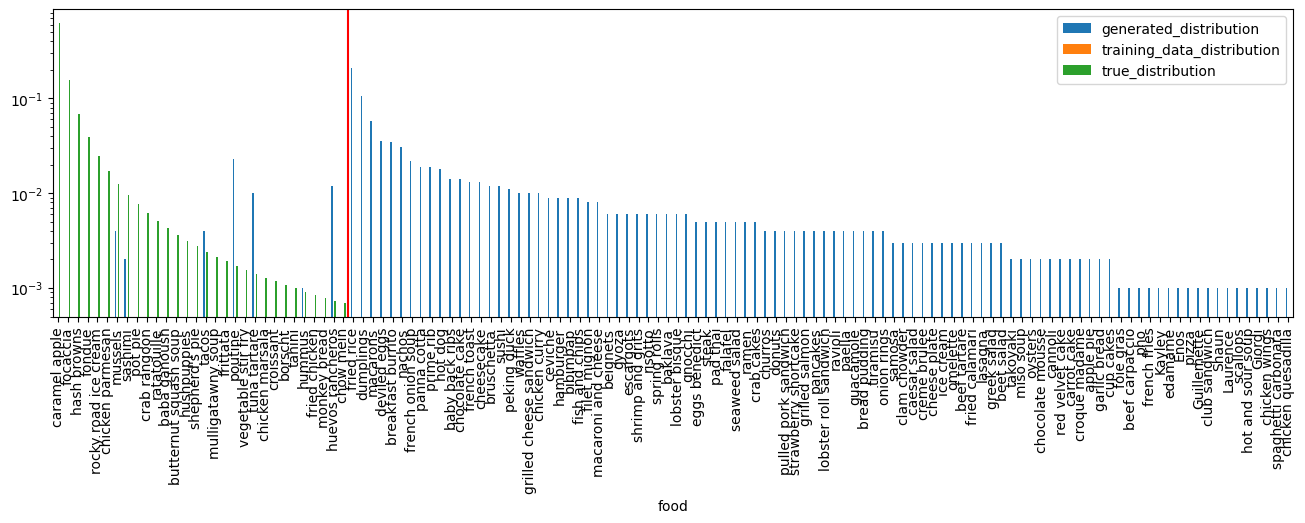

In [21]:
comparison_df.plot.bar(figsize=(16, 4))
plt.yscale("log")
plt.axvline(30 - 0.5, color='red')

# Hallucination and monofact rate

In [22]:
# Only for melessa
hallucination_rate = len(melessa_df[~melessa_df['food'].isin(true_food_names)]) / len(melessa_df)
hallucination_rate

0.944

In [23]:
generated_foods = pd.Series([str(d) for d in dataset.dataset_splitted])

# Number of Facts that appear exactly once in dataset
monofact_number = np.sum(generated_foods.value_counts() == 1)
monofact_rate = monofact_number / len(dataset.dataset_splitted)
monofact_rate

0.04526

# Compare distributions on food items (global, conditioned on name)

In [24]:
n_sequences = 100
from collections import defaultdict
collected_generations = defaultdict(lambda: 0)

for name in dataset.sampled_names:
    name_tokenized = dataset.word2id[name]
    for _ in range(n_sequences):
        x = torch.Tensor([0, name_tokenized]).unsqueeze(0).long().to("cuda")
        y_gen = model.generate(x, 1, do_sample=True)
        food_item = dataset.decode([y_gen[0][2]])[0]
        collected_generations[food_item] += 1

In [25]:
for item in collected_generations:
    collected_generations[item] /= (n_sequences * len(dataset.sampled_names))

In [26]:
dataset_foods = defaultdict(lambda: 0)
for item in dataset.dataset_tokenized:
    food_item = dataset.decode(item)[-1]
    dataset_foods[food_item] += 1

dataset_food_distribution = defaultdict(lambda: 0)
for item in dataset_foods:
    dataset_food_distribution[item] = dataset_foods[item] / sum(dataset_foods.values())

In [27]:
comparison_df = pd.DataFrame({'food': collected_generations.keys()})
comparison_df['generated_distribution'] = comparison_df['food'].apply(lambda x: collected_generations[x])
comparison_df['training_data_distribution'] = comparison_df['food'].apply(lambda x: dataset_food_distribution[x])
# comparison_df = comparison_df.set_index('food')

In [28]:
comparison_df

,food,generated_distribution,training_data_distribution
0,fried rice,0.2008,0.19332
1,pulled pork sandwich,0.0068,0.00780
2,caesar salad,0.0022,0.00208
3,poutine,0.0271,0.02404
4,breakfast burrito,0.0497,0.04742
...,...,...,...
159,Rossy,0.0001,0.00000
160,Filberto,0.0001,0.00000
161,Ninetta,0.0001,0.00000
162,Bella,0.0001,0.00000


<Axes: >

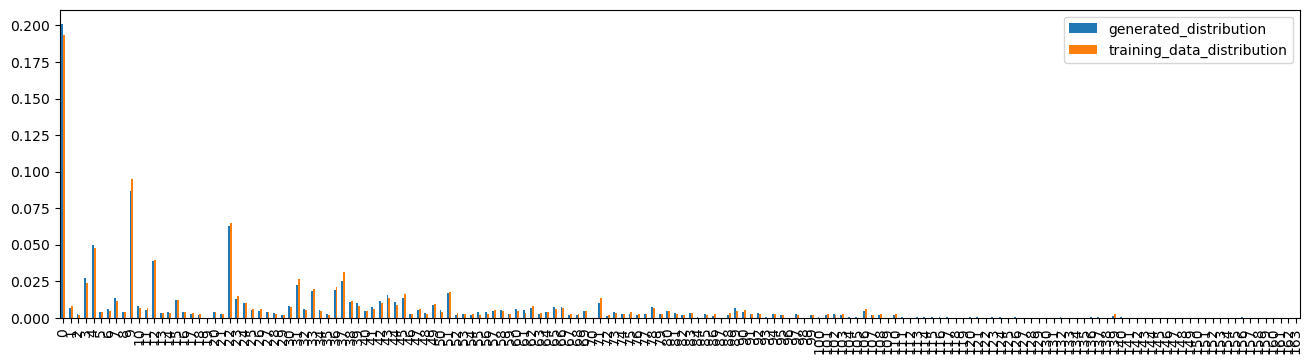

In [29]:
comparison_df.plot.bar(figsize=(16, 4))

# Compare distributions on fact level, no conditioning

In [30]:
n_sequences = 100 * len(dataset.sampled_names)
collected_generations = defaultdict(lambda: 0)

start_token = dataset.word2id["<s>"]
x = torch.Tensor([start_token]).unsqueeze(0).long().to("cuda")
for i in range(n_sequences):
    y_gen = model.generate(x, 2, do_sample=True)
    name = dataset.decode([y_gen[0][1]])[0]
    food = dataset.decode([y_gen[0][2]])[0]
    collected_generations[f"{name} {food_item}"] += 1 


In [74]:
true_distribution = defaultdict(lambda: 0)
for item in collected_generations:
    food = " ".join(item.split(" ")[1:])

    if food in dataset.foods:
        food_index = dataset.foods.index(food)
    elif food.strip(" ") in dataset.foods:
        food_index = dataset.foods.index(food.strip(" "))
    elif food + " " in dataset.foods:
        food_index = dataset.foods.index(food + " ")
    if item.split(" ")[0] in dataset.distribution_of_names:
        true_distribution[item] = dataset.foods_weighted[food_index] * dataset.distribution_of_names[item.split(" ")[0]]

dataset_distribution = defaultdict(lambda: 0)
for item in dataset.dataset:
    dataset_distribution[" ".join(item.split(" ")[1:])] += 1


In [79]:
comparison_df = pd.DataFrame({'fact': collected_generations.keys()})
comparison_df['generated_distribution'] = comparison_df['fact'].apply(lambda x: collected_generations[x] / sum(collected_generations.values()))
comparison_df['training_data_distribution'] = comparison_df['fact'].apply(lambda x: dataset_distribution[x] / sum(dataset_distribution.values()))
comparison_df["true_distribution"] = comparison_df['fact'].apply(lambda x: true_distribution[x])
comparison_df = comparison_df.set_index('fact')

In [80]:
comparison_df

,generated_distribution,training_data_distribution,true_distribution
fact,,,
Isadora breakfast burrito,0.0113,0.00052,0.000481
Shellie breakfast burrito,0.0128,0.00040,0.000481
Cal breakfast burrito,0.0136,0.00040,0.000481
Rossy breakfast burrito,0.0094,0.00032,0.000481
Archibald breakfast burrito,0.0093,0.00050,0.000481
...,...,...,...
onion rings breakfast burrito,0.0002,0.00000,0.000000
pizza breakfast burrito,0.0001,0.00000,0.000000
lasagna breakfast burrito,0.0001,0.00000,0.000000


<Axes: xlabel='fact'>

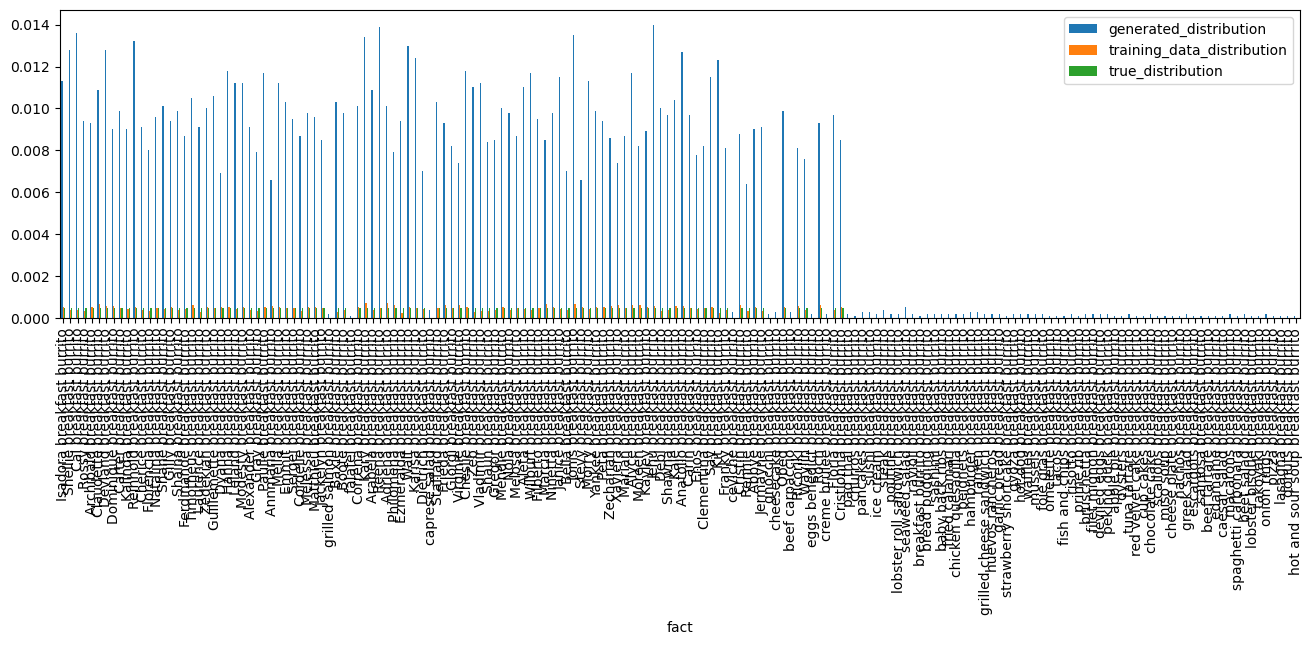

In [78]:
comparison_df.plot.bar(figsize=(16, 4))

In [49]:
comparison_df

,generated_distribution,true_distribution
fact,,
Isadora breakfast burrito,0.0113,0.048102
Shellie breakfast burrito,0.0128,0.048102
Cal breakfast burrito,0.0136,0.048102
Rossy breakfast burrito,0.0094,0.048102
Archibald breakfast burrito,0.0093,0.048102
...,...,...
onion rings breakfast burrito,0.0002,0.048102
pizza breakfast burrito,0.0001,0.048102
lasagna breakfast burrito,0.0001,0.048102
